In [1]:
import xarray as xr
import numpy as np
import numpy as np
import xarray as xr
import os
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import geopandas as gpd
import pycountry
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from shapely.geometry import box

In [2]:
diri = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power"
models = [
    "ACCESS-CM2", "CanESM5", "CMCC-CM2-SR5", "CMCC-ESM2",
    "HadGEM3-GC31-LL", "HadGEM3-GC31-MM", "MRI-ESM2-0"
]
periods = ["historical", "ssp585"]
filename="daily_solar_power_*.nc"
short_per=["_BOC", "_EOC"]

In [ ]:
for model in models:
    for period, short in zip(periods, short_per):
        file_path = os.path.join(diri, model+"_1x1grid", period, filename)
        print(file_path)
        # Construct the file path
        if os.path.exists(file_path):
            ds = xr.open_dataset(file_path)
            print(f"Processing {file_path}")
            
           

In [5]:
ds=xr.open_dataset("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power/ACCESS-CM2_1x1grid/historical/daily_solar_power_2000.nc")
ds

<xarray.Dataset> Size: 6MB
Dimensions:              (x: 48, y: 40, time: 366)
Coordinates:
  * x                    (x) float64 384B -12.0 -11.0 -10.0 ... 33.0 34.0 35.0
    lon                  (x) float64 384B ...
  * y                    (y) float64 320B 33.0 34.0 35.0 36.0 ... 70.0 71.0 72.0
    lat                  (y) float64 320B ...
  * time                 (time) datetime64[ns] 3kB 2000-01-01 ... 2000-12-31
    weekofyear           (time) int64 3kB ...
Data variables:
    specific generation  (time, y, x) float64 6MB ...

In [6]:
import os, glob
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

diri     = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power"
periods  = ["historical","ssp585"]
pattern  = "daily_solar_power_*.nc"

def preprocess(ds):
    return ds.drop_vars("weekofyear", errors="ignore")

def preprocess(ds):
    return ds.drop_vars("weekofyear", errors="ignore")

records = []

for model in models:
    for period in periods:
        files = sorted(glob.glob(os.path.join(
            diri, f"{model}_1x1grid", period, pattern
        )))
        if not files:
            continue

        ds = xr.open_mfdataset(
            files,
            concat_dim="time",
            combine="nested",
            preprocess=preprocess,
            decode_times=True,
            data_vars="minimal",
            coords="minimal",
            compat="override",
        )

        # 1) collapse spatial dims first
        sp_med = ds["specific generation"].median(dim=["y","x"])

        # 2) Group by day‐of‐year, then take the 50th percentile along time
        daily_median = (
            sp_med
            .groupby(sp_med.time.dt.dayofyear)
            .quantile(0.5, dim="time")    # 0.5 quantile == median
        )

        # Convert to pandas Series, then name & reset index
        series = daily_median.to_series().rename("median_gen")
        clim   = series.reset_index()   # yields DataFrame with ['dayofyear','median_gen']

        # Add metadata
        clim["model"]  = model
        clim["period"] = period
        records.append(clim)

        ds.close()

clim_df = pd.concat(records, ignore_index=True)

In [4]:
# Step 1: get monthly values instead of daily
# Assuming 'clim_df' has time information originally, or you can redo this from xarray

# If 'dayofyear' is present but not month, you can recover from original xarray dataset,
# but let's assume you already have a monthly version:
# Let's group by month now

# Map dayofyear → month (approximate, if needed)
# Better: just re-do this part using xarray to get actual month

records = []

for model in models:
    for period in periods:
        files = sorted(glob.glob(os.path.join(
            diri, f"{model}_1x1grid", period, pattern
        )))
        if not files:
            continue

        ds = xr.open_mfdataset(
            files,
            concat_dim="time",
            combine="nested",
            preprocess=preprocess,
            decode_times=True,
            data_vars="minimal",
            coords="minimal",
            compat="override",
        )

        # 1) collapse spatial dims first
        sp_med = ds["specific generation"].median(dim=["y","x"])

        # 2) group by month, take median per month
        monthly_median = (
            sp_med
            .groupby(sp_med.time.dt.month)
            .quantile(0.5, dim="time")
        )

        series = monthly_median.to_series().rename("median_gen")
        clim = series.reset_index()  # ['month', 'median_gen']
        clim["model"] = model
        clim["period"] = period
        records.append(clim)

        ds.close()

# Merge
monthly_df = pd.concat(records, ignore_index=True)


In [38]:
monthly_df

,month,median_gen,model,period
0,1,0.205605,ACCESS-CM2,historical
1,2,0.648908,ACCESS-CM2,historical
2,3,1.338696,ACCESS-CM2,historical
3,4,2.313404,ACCESS-CM2,historical
4,5,3.551844,ACCESS-CM2,historical
...,...,...,...,...
163,8,3.904771,MRI-ESM2-0,ssp585
164,9,2.612807,MRI-ESM2-0,ssp585
165,10,1.006404,MRI-ESM2-0,ssp585
166,11,0.287606,MRI-ESM2-0,ssp585


In [10]:
import os, glob
import xarray as xr
import pandas as pd

diri     = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power"
periods  = ["historical","ssp585"]
pattern  = "daily_solar_power_*.nc"

def preprocess(ds):
    return ds.drop_vars("weekofyear", errors="ignore")

# 1) auto-discover model names from dirs
models = [
    d.split("_1x1grid")[0]
    for d in os.listdir(diri)
    if d.endswith("_1x1grid")
]

monthly_records = []
yearly_records  = []

for model in models:
    for period in periods:
        search = os.path.join(diri, f"{model}_1x1grid", period, pattern)
        files  = sorted(glob.glob(search))
        if not files:
            continue

        ds = xr.open_mfdataset(
            files,
            concat_dim="time", combine="nested",
            preprocess=preprocess,
            decode_times=True,
            data_vars="minimal",
            coords="minimal",
            compat="override"
        )

        # collapse spatial dims → 1D time series of CF
        sp_mean = ds["specific generation"].mean(dim=["x","y"])

        # 2) monthly‐sum (labels at month‐end)
        monthly = sp_mean.resample(time="M").sum()
        mf = (
            monthly
            .to_dataframe(name="cf_sum")
            .reset_index()
        )
        mf["model"]     = model
        mf["period"]    = period
        mf["year"]      = mf["time"].dt.year
        mf["month"]     = mf["time"].dt.month
        monthly_records.append(mf)

        # 3) yearly‐sum (labels at year‐end)
        yearly = sp_mean.resample(time="Y").sum()
        yf = (
            yearly
            .to_dataframe(name="cf_sum")
            .reset_index()
        )
        yf["model"]     = model
        yf["period"]    = period
        yf["year"]      = yf["time"].dt.year
        yf["month"]     = None
        yearly_records.append(yf)

        ds.close()

# 4) Merge
monthly_df = pd.concat(monthly_records, ignore_index=True)
yearly_df  = pd.concat(yearly_records,  ignore_index=True)

# 5) (Optional) aggregate across models:
monthly_totals = (
    monthly_df
    .groupby(["period","year","month"])["cf_sum"]
    .mean()      # or .sum() if you want sum over models
    .reset_index()
)
yearly_totals = (
    yearly_df
    .groupby(["period","year"])["cf_sum"]
    .mean()
    .reset_index()
)

# Now monthly_totals and yearly_totals hold exactly what you asked:
print(monthly_totals.head())
print(yearly_totals.head())


/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/xarray/groupers.py:487: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(
/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/xarray/groupers.py:487: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/xarray/groupers.py:487: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(
/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/xarray/groupers.py:487: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/si

       period  year  month     cf_sum
0  historical  1980      1  27.837546
1  historical  1980      2  39.044945
2  historical  1980      3  57.734282
3  historical  1980      4  71.639607
4  historical  1980      5  87.378732
       period  year      cf_sum
0  historical  1980  723.349391
1  historical  1981  712.912105
2  historical  1982  720.798571
3  historical  1983  706.653656
4  historical  1984  709.717185


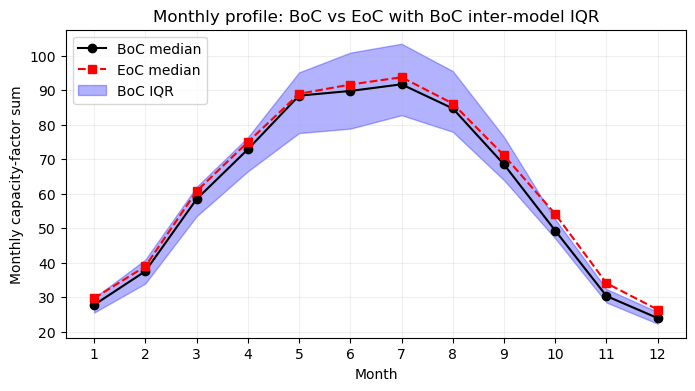

In [9]:
# …after you’ve built `monthly_df` (and/or `monthly_totals`) add:

import matplotlib.pyplot as plt

# 1) compute median and IQR across models+years for each period & month
g = monthly_df.groupby(['period','month'])['cf_sum']
monthly_med = g.median().unstack('period')    # index=1–12, cols=['historical','ssp585']
monthly_p25 = g.quantile(0.25).unstack('period')
monthly_p75 = g.quantile(0.75).unstack('period')

# 2) plot
months = monthly_med.index
plt.figure(figsize=(8,4))

# BoC & EoC median curves
plt.plot(months, monthly_med['historical'], 'o-', label='BoC median', color='k')
plt.plot(months, monthly_med['ssp585'],    's--', label='EoC median', color='r')

# shade BoC inter-model IQR
plt.fill_between(
    months,
    monthly_p25['historical'],
    monthly_p75['historical'],
    color='blue', alpha=0.3,
    label='BoC IQR'
)

plt.xticks(months)
plt.xlabel('Month')
plt.ylabel('Monthly capacity‐factor sum')
plt.title('Monthly profile: BoC vs EoC with BoC inter‐model IQR')
plt.grid(alpha=0.2)
plt.legend(loc='upper left')
plt.show()

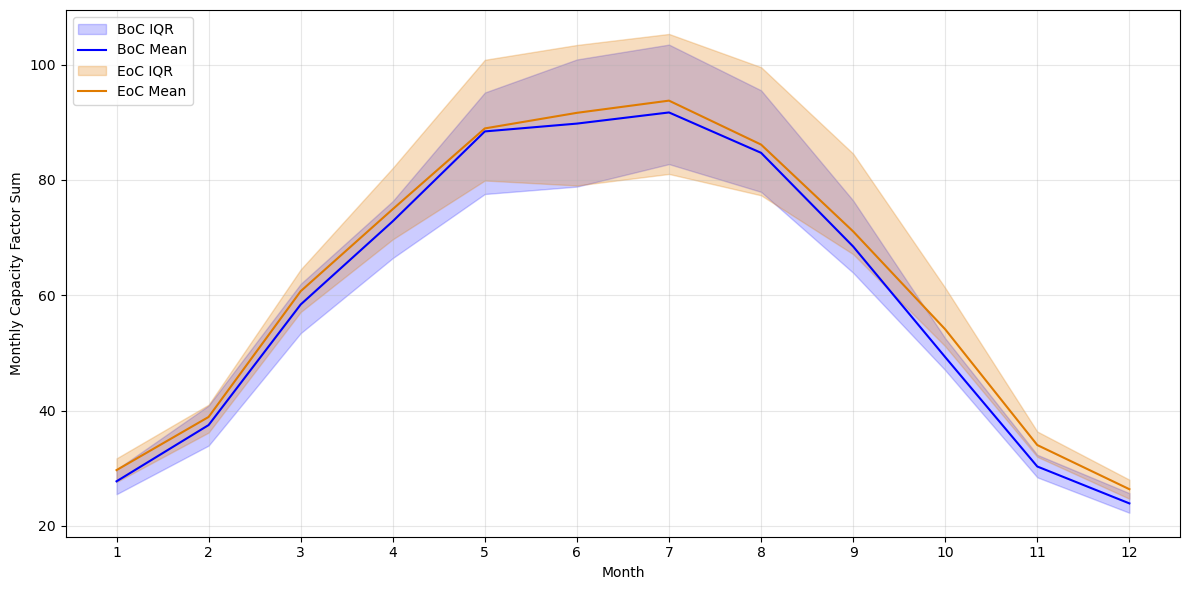

In [10]:
import matplotlib.pyplot as plt

# 1) compute median and IQR across models+years for each period & month
g = monthly_df.groupby(['period', 'month'])['cf_sum']
monthly_med = g.median().unstack('period')    # index=1–12, cols=['historical','ssp585']
monthly_p25 = g.quantile(0.25).unstack('period')
monthly_p75 = g.quantile(0.75).unstack('period')

# 2) plot
months = monthly_med.index
plt.figure(figsize=(12, 6))

# BoC IQR shading
plt.fill_between(
    months,
    monthly_p25['historical'],
    monthly_p75['historical'],
    color='blue',
    alpha=0.2,
    label='BoC IQR'
)

# BoC median
plt.plot(
    months,
    monthly_med['historical'],
    label='BoC Mean',
    color='blue'
)

# EoC IQR shading
plt.fill_between(
    months,
    monthly_p25['ssp585'],
    monthly_p75['ssp585'],
    color='#e07b00',  # slightly darker orange
    alpha=0.25,
    label='EoC IQR'
)

# EoC median
plt.plot(
    months,
    monthly_med['ssp585'],
    label='EoC Mean',
    color='#e07b00'
)

plt.xticks(months)
plt.xlabel('Month')
plt.ylabel('Monthly Capacity Factor Sum')
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


In [30]:
# Calculate yearly inter-model and inter-annual variability for EoC (ssp585)

# 1) select just the EoC yearly sums
eoc = yearly_df[yearly_df.period == "ssp585"]

# 2) inter-model variability: for each year across models
g_year = eoc.groupby("year")["cf_sum"]
p25_y  = g_year.quantile(0.25)
p75_y  = g_year.quantile(0.75)
med_y  = g_year.median()
iqr_pct_year = (p75_y - p25_y) / med_y * 100

# overall mean inter-model variability (mean IQR% across years)
im_var = iqr_pct_year.mean()

# 3) inter-annual variability: for each model across years
g_mod = eoc.groupby("model")["cf_sum"]
p25_m = g_mod.quantile(0.25)
p75_m = g_mod.quantile(0.75)
med_m = g_mod.median()
iqr_pct_model = (p75_m - p25_m) / med_m * 100

# overall mean inter-annual variability (mean IQR% across models)
ia_var = iqr_pct_model.mean()

# 4) report
print(f"EoC inter-model variability (mean IQR% across years)   : {im_var:.1f}%")
print(f"EoC inter-annual variability (mean IQR% across models): {ia_var:.1f}%")

EoC inter-model variability (mean IQR% across years)   : 16.2%
EoC inter-annual variability (mean IQR% across models): 2.1%


In [11]:
# compute inter-model and inter-annual variability for any period
def compute_var(df, period_name):
    print(f"\n=== {period_name} ===")
    # inter-model (across models for each year)
    im = (
        df.groupby("year")["cf_sum"]
          .quantile([0.25, 0.5, 0.75])
          .unstack()
          .rename(columns={0.25:"p25", 0.5:"median", 0.75:"p75"})
    )
    im["iqr_pct"] = (im["p75"] - im["p25"]) / im["median"] * 100
    print("Inter‐model IQR% by year:\n", im[["p25","median","p75","iqr_pct"]])
    print(f"Mean inter‐model variability: {im['iqr_pct'].mean():.2f}%")

    # inter-annual (across years for each model)
    ia = (
        df.groupby("model")["cf_sum"]
          .quantile([0.25, 0.5, 0.75])
          .unstack()
          .rename(columns={0.25:"p25", 0.5:"median", 0.75:"p75"})
    )
    ia["iqr_pct"] = (ia["p75"] - ia["p25"]) / ia["median"] * 100
    print("\nInter‐annual IQR% by model:\n", ia[["p25","median","p75","iqr_pct"]])
    print(f"Mean inter‐annual variability: {ia['iqr_pct'].mean():.2f}%")

# EoC
eoc = yearly_df[yearly_df.period=="ssp585"]
compute_var(eoc, "End-of-Century (ssp585)")

# BOC
boc = yearly_df[yearly_df.period=="boc"]
compute_var(boc, "Beginning-of-Century (boc)")


=== End-of-Century (ssp585) ===
Inter‐model IQR% by year:
              p25      median         p75    iqr_pct
year                                               
2065  694.613066  753.835990  807.877543  15.025082
2066  696.495520  747.325191  809.134695  15.072311
2067  690.346077  753.185565  822.351216  17.526244
2068  684.299416  730.257631  830.929403  20.079213
2069  708.030328  749.412934  813.706799  14.101234
2070  709.429399  755.765294  811.505973  13.506386
2071  703.568886  738.169080  813.246084  14.858005
2072  695.620101  738.788910  827.262673  17.818699
2073  681.592137  731.657005  827.269055  19.910548
2074  704.653158  744.539143  819.738851  15.457306
2075  714.643461  752.907550  815.164875  13.351097
2076  704.912032  733.064570  815.125817  15.034663
2077  710.290203  752.918935  815.309006  13.948222
2078  708.244895  755.730161  814.271742  14.029723
2079  680.169353  734.171428  822.532552  19.391002
2080  692.615913  744.647192  817.840305  16.816607
2081

KeyError: 'p75'

In [13]:
# ...existing code...

def compute_var(df, period_name):
    print(f"\n=== {period_name} ===")
    if df.empty:
        print("  ⚠️ No data available for this period.")
        return

    # 1) inter‐model variability (across models for each year)
    im = df.groupby("year")["cf_sum"].agg(
        p25=lambda x: x.quantile(0.25),
        median="median",
        p75=lambda x: x.quantile(0.75),
    )
    im["iqr_pct"] = (im["p75"] - im["p25"]) / im["median"] * 100
    print("Inter‐model IQR% by year:\n", im[["p25","median","p75","iqr_pct"]])
    print(f"Mean inter‐model variability: {im['iqr_pct'].mean():.2f}%")

    # 2) inter‐annual variability (across years for each model)
    ia = df.groupby("model")["cf_sum"].agg(
        p25=lambda x: x.quantile(0.25),
        median="median",
        p75=lambda x: x.quantile(0.75),
    )
    ia["iqr_pct"] = (ia["p75"] - ia["p25"]) / ia["median"] * 100
    print("\nInter‐annual IQR% by model:\n", ia[["p25","median","p75","iqr_pct"]])
    print(f"Mean inter‐annual variability: {ia['iqr_pct'].mean():.2f}%")

# …existing compute_var(…) definition…

# EoC
eoc = yearly_df[yearly_df.period == "ssp585"]
compute_var(eoc, "End-of-Century (ssp585)")

# BOC ← use historical
boc = yearly_df[yearly_df.period == "historical"]
compute_var(boc, "Beginning-of-Century (historical)")


=== End-of-Century (ssp585) ===
Inter‐model IQR% by year:
              p25      median         p75    iqr_pct
year                                               
2065  694.613066  753.835990  807.877543  15.025082
2066  696.495520  747.325191  809.134695  15.072311
2067  690.346077  753.185565  822.351216  17.526244
2068  684.299416  730.257631  830.929403  20.079213
2069  708.030328  749.412934  813.706799  14.101234
2070  709.429399  755.765294  811.505973  13.506386
2071  703.568886  738.169080  813.246084  14.858005
2072  695.620101  738.788910  827.262673  17.818699
2073  681.592137  731.657005  827.269055  19.910548
2074  704.653158  744.539143  819.738851  15.457306
2075  714.643461  752.907550  815.164875  13.351097
2076  704.912032  733.064570  815.125817  15.034663
2077  710.290203  752.918935  815.309006  13.948222
2078  708.244895  755.730161  814.271742  14.029723
2079  680.169353  734.171428  822.532552  19.391002
2080  692.615913  744.647192  817.840305  16.816607
2081

In [32]:
import numpy as np

# select EoC yearly sums
eoc = yearly_df[yearly_df.period == "ssp585"]

# 1) Inter‐model variability: for each year, IQR across models
im = (
    eoc
    .groupby("year")["cf_sum"]
    .quantile([0.25, 0.5, 0.75])
    .unstack(level=1)
    .rename(columns={0.25: "p25", 0.5: "median", 0.75: "p75"})
)
im["iqr_pct"] = (im["p75"] - im["p25"]) / im["median"] * 100

print("Inter-model IQR% by year:")
print(im[["p25", "median", "p75", "iqr_pct"]])

# overall mean inter-model IQR%
mean_im = im["iqr_pct"].mean()
print(f"\nMean inter-model variability over years: {mean_im:.2f}%")

# 2) Inter‐annual variability: for each model, IQR across years
ia = (
    eoc
    .groupby("model")["cf_sum"]
    .quantile([0.25, 0.5, 0.75])
    .unstack(level=1)
    .rename(columns={0.25: "p25", 0.5: "median", 0.75: "p75"})
)
ia["iqr_pct"] = (ia["p75"] - ia["p25"]) / ia["median"] * 100

print("\nInter-annual IQR% by model:")
print(ia[["p25", "median", "p75", "iqr_pct"]])

# overall mean inter-annual IQR%
mean_ia = ia["iqr_pct"].mean()
print(f"\nMean inter-annual variability over models: {mean_ia:.2f}%")

Inter-model IQR% by year:
             p25      median         p75    iqr_pct
year                                               
2065  694.613066  753.835990  807.877543  15.025082
2066  696.495520  747.325191  809.134695  15.072311
2067  690.346077  753.185565  822.351216  17.526244
2068  684.299416  730.257631  830.929403  20.079213
2069  708.030328  749.412934  813.706799  14.101234
2070  709.429399  755.765294  811.505973  13.506386
2071  703.568886  738.169080  813.246084  14.858005
2072  695.620101  738.788910  827.262673  17.818699
2073  681.592137  731.657005  827.269055  19.910548
2074  704.653158  744.539143  819.738851  15.457306
2075  714.643461  752.907550  815.164875  13.351097
2076  704.912032  733.064570  815.125817  15.034663
2077  710.290203  752.918935  815.309006  13.948222
2078  708.244895  755.730161  814.271742  14.029723
2079  680.169353  734.171428  822.532552  19.391002
2080  692.615913  744.647192  817.840305  16.816607
2081  705.982001  764.358776  823.2524

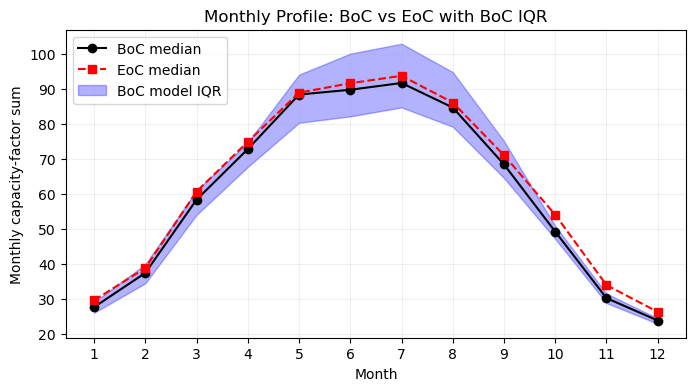

In [28]:
import matplotlib.pyplot as plt

# assume `monthly_med` and `boc_iqr_df` are in scope from previous cells

fig, ax = plt.subplots(figsize=(8, 4))

# months 1–12
months = monthly_med.index

# plot medians
ax.plot(months, monthly_med['historical'], 'o-', color='k', label='BoC median')
ax.plot(months, monthly_med['ssp585'],    's--', color='r', label='EoC median')

# shade BoC inter‐model IQR
ax.fill_between(
    boc_iqr_df['month'],
    boc_iqr_df['p25'],
    boc_iqr_df['p75'],
    color='blue', alpha=0.3,
    label='BoC model IQR'
)

ax.set_xticks(months)
ax.set_xlabel('Month')
ax.set_ylabel('Monthly capacity‐factor sum')
ax.set_title('Monthly Profile: BoC vs EoC with BoC IQR')
ax.grid(alpha=0.2)
ax.legend(loc='upper left')

plt.show()

In [ ]:
# Step 1: average across years (interannual mean), and interannual std
interannual = (
    cf_df
    .groupby(["model", "period", "month"])
    .agg(mean_cf=("cf_sum", "mean"),    # interannual mean
         std_ia=("cf_sum", "std"))      # interannual std (across years)
    .reset_index()
)

# Step 2: average across models (intermodel mean + std)
final_summary = (
    interannual
    .groupby(["period", "month"])
    .agg(
        mean_cf=("mean_cf", "mean"),                  # final monthly mean CF across models
        intermodel_std=("mean_cf", "std"),            # intermodel variability
        interannual_std=("std_ia", "mean")            # average interannual variability
    )
    .reset_index()
)

# Optional: add % versions
final_summary["intermodel_std_pct"] = 100 * final_summary["intermodel_std"] / final_summary["mean_cf"]
final_summary["interannual_std_pct"] = 100 * final_summary["interannual_std"] / final_summary["mean_cf"]


In [12]:
final_summary

,period,month,mean_cf,intermodel_std,interannual_std,intermodel_std_pct,interannual_std_pct
0,historical,1,27.750513,2.278105,2.177365,8.209236,7.846216
1,historical,2,37.214759,3.762554,2.672095,10.110382,7.180202
2,historical,3,57.666125,5.885567,3.859540,10.206282,6.692907
3,historical,4,71.757392,6.846857,3.410745,9.541675,4.753162
4,historical,5,87.416535,10.106951,2.685922,11.561830,3.072556
5,historical,6,90.724488,11.947131,2.179672,13.168585,2.402518
6,historical,7,93.500236,11.705461,2.166607,12.519178,2.317221
7,historical,8,86.801501,9.706837,2.063649,11.182799,2.377435
8,historical,9,70.030287,7.032327,2.612935,10.041836,3.731151
9,historical,10,49.900377,3.605053,2.917254,7.224500,5.846155


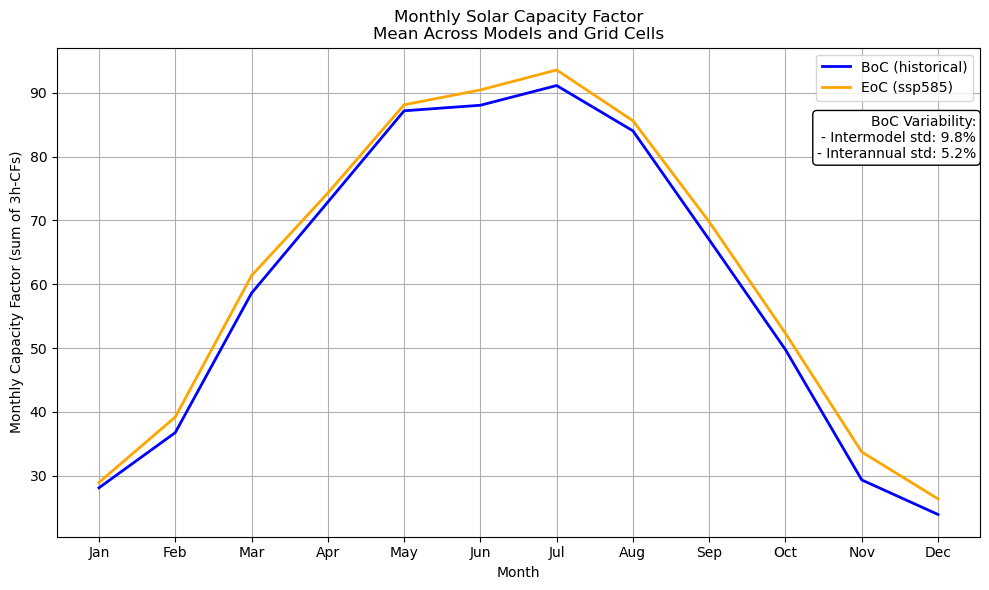

In [21]:
import matplotlib.pyplot as plt

# Ensure month is sorted
final_summary = final_summary.sort_values(["period", "month"])

# Split BoC and EoC
boc = final_summary[final_summary["period"] == "historical"]
eoc = final_summary[final_summary["period"] == "ssp585"]

# Start plot
plt.figure(figsize=(10, 6))

# Plot mean CF lines
plt.plot(boc["month"], boc["mean_cf"], label="BoC (historical)", color="blue", linewidth=2)
plt.plot(eoc["month"], eoc["mean_cf"], label="EoC (ssp585)", color="orange", linewidth=2)

# Labels & aesthetics
plt.xlabel("Month")
plt.ylabel("Monthly Capacity Factor (sum of 3h-CFs)")
plt.title("Monthly Solar Capacity Factor\nMean Across Models and Grid Cells")
plt.xticks(ticks=range(1, 13), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                                       "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.grid(True)
plt.legend()

# Compute summary % values for BoC
boc_intermodel = boc["intermodel_std_pct"].mean()
boc_interannual = boc["interannual_std_pct"].mean()

# Add text box with variability
plt.text(
    12.5, max(boc["mean_cf"]) * 0.95,
    f"BoC Variability:\n"
    f"- Intermodel std: {boc_intermodel:.1f}%\n"
    f"- Interannual std: {boc_interannual:.1f}%",
    ha="right",
    va="top",
    fontsize=10,
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3")
)

plt.tight_layout()
plt.show()


In [40]:
monthly_df

,month,median_gen,model,period
0,1,0.205605,ACCESS-CM2,historical
1,2,0.648908,ACCESS-CM2,historical
2,3,1.338696,ACCESS-CM2,historical
3,4,2.313404,ACCESS-CM2,historical
4,5,3.551844,ACCESS-CM2,historical
...,...,...,...,...
163,8,3.904771,MRI-ESM2-0,ssp585
164,9,2.612807,MRI-ESM2-0,ssp585
165,10,1.006404,MRI-ESM2-0,ssp585
166,11,0.287606,MRI-ESM2-0,ssp585


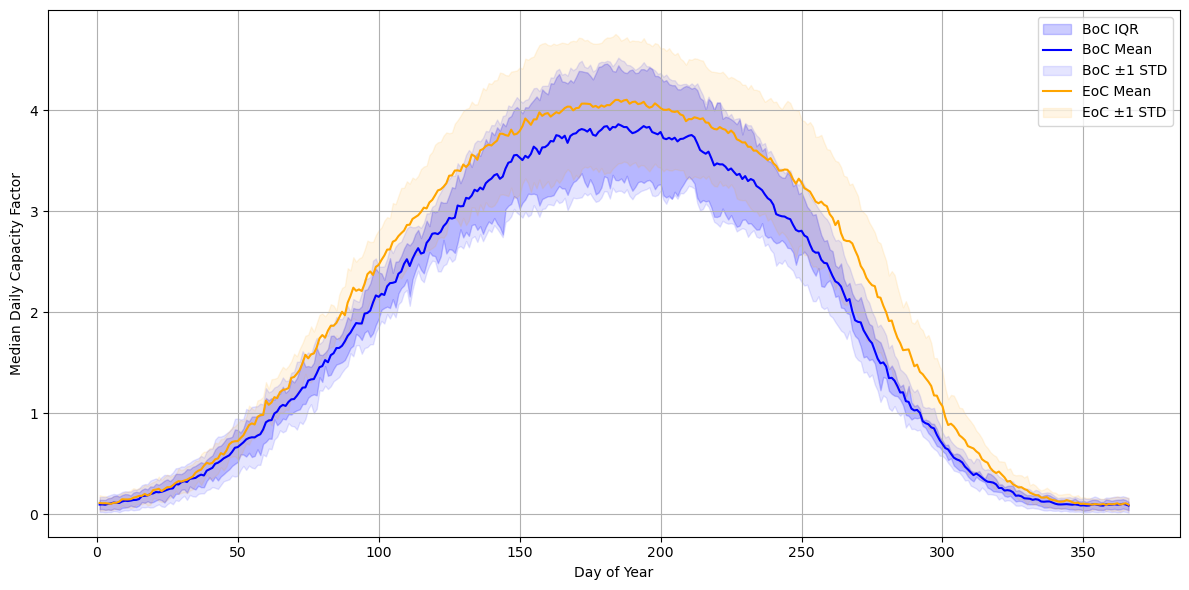

In [6]:
import seaborn as sns

# Ensure dayofyear is sorted properly
clim_df = clim_df.sort_values(by=["period", "model", "dayofyear"])

# Pivot table: rows = dayofyear, columns = model, values = median_gen
boc = clim_df[clim_df["period"] == "historical"]
eoc = clim_df[clim_df["period"] == "ssp585"]

def summary_stats(df):
    pivot = df.pivot(index="dayofyear", columns="model", values="median_gen")
    stats = pd.DataFrame({
        "mean": pivot.mean(axis=1),
        "std": pivot.std(axis=1),
        "q25": pivot.quantile(0.25, axis=1),
        "q75": pivot.quantile(0.75, axis=1),
    })
    stats["dayofyear"] = stats.index
    return stats

boc_stats = summary_stats(boc)
eoc_stats = summary_stats(eoc)

# Plot
plt.figure(figsize=(12, 6))

# BoC IQR shading
plt.fill_between(
    boc_stats["dayofyear"],
    boc_stats["q25"],
    boc_stats["q75"],
    color="blue",
    alpha=0.2,
    label="BoC IQR"
)

# BoC Mean ± STD
plt.plot(boc_stats["dayofyear"], boc_stats["mean"], label="BoC Mean", color="blue")
plt.fill_between(
    boc_stats["dayofyear"],
    boc_stats["mean"] - boc_stats["std"],
    boc_stats["mean"] + boc_stats["std"],
    color="blue",
    alpha=0.1,
    label="BoC ±1 STD"
)

# EoC Mean ± STD
plt.plot(eoc_stats["dayofyear"], eoc_stats["mean"], label="EoC Mean", color="orange")
plt.fill_between(
    eoc_stats["dayofyear"],
    eoc_stats["mean"] - eoc_stats["std"],
    eoc_stats["mean"] + eoc_stats["std"],
    color="orange",
    alpha=0.1,
    label="EoC ±1 STD"
)

plt.xlabel("Day of Year")
plt.ylabel("Median Daily Capacity Factor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


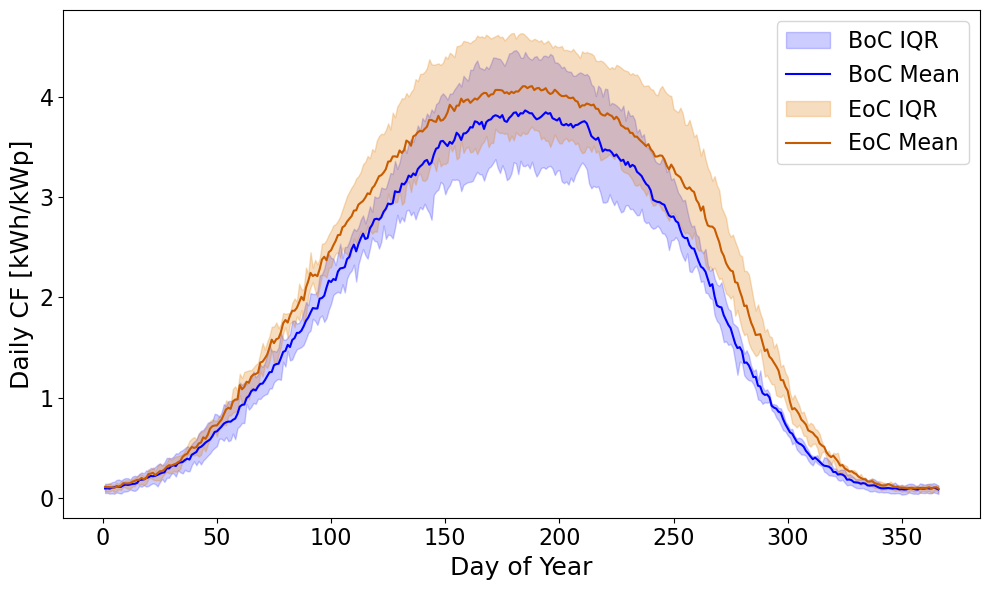

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure dayofyear is sorted properly
clim_df = clim_df.sort_values(by=["period", "model", "dayofyear"])

# Split into historical (BoC) and future (EoC)
boc = clim_df[clim_df["period"] == "historical"]
eoc = clim_df[clim_df["period"] == "ssp585"]

def summary_stats(df):
    pivot = df.pivot(index="dayofyear", columns="model", values="median_gen")
    stats = pd.DataFrame({
        "mean": pivot.mean(axis=1),
        "q25": pivot.quantile(0.25, axis=1),
        "q75": pivot.quantile(0.75, axis=1),
    })
    stats["dayofyear"] = stats.index
    return stats

boc_stats = summary_stats(boc)
eoc_stats = summary_stats(eoc)

# Plot
plt.figure(figsize=(10, 6))

# BoC IQR shading
plt.fill_between(
    boc_stats["dayofyear"],
    boc_stats["q25"],
    boc_stats["q75"],
    color="blue",
    alpha=0.2,
    label="BoC IQR"
)

# BoC Mean
plt.plot(boc_stats["dayofyear"], boc_stats["mean"], label="BoC Mean", color="blue")

# EoC IQR shading with a slightly darker orange
plt.fill_between(
    eoc_stats["dayofyear"],
    eoc_stats["q25"],
    eoc_stats["q75"],
    color="#e07b00",  # slightly darker orange than default
    alpha=0.25,
    label="EoC IQR"
)

# EoC Mean
plt.plot(eoc_stats["dayofyear"], eoc_stats["mean"], label="EoC Mean", color="#c75b00" )

plt.xlabel("Day of Year", fontsize=18)
plt.ylabel("Daily CF [kWh/kWp]", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid(False)
plt.tight_layout()
plt.savefig("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/yearly_curve.pdf", bbox_inches='tight', dpi=300)
plt.show()


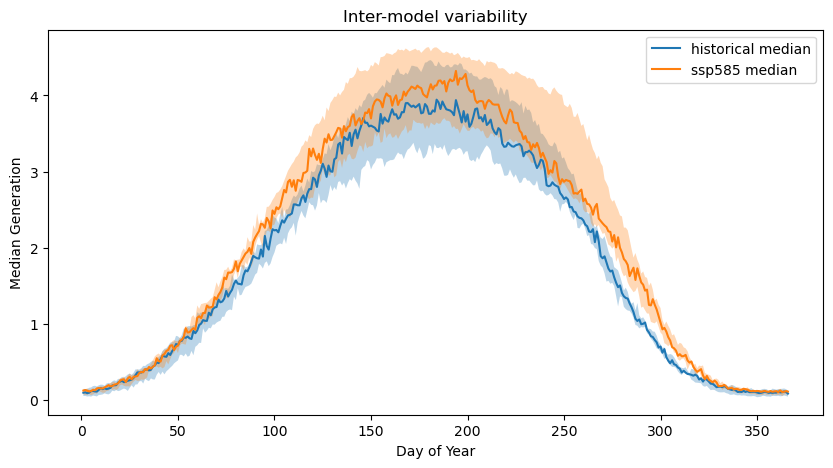

In [5]:
# 1) Inter-model variability across models
grouped = clim_df.groupby(['period','dayofyear'])['median_gen']
im_median = grouped.median().unstack(level=0)    # DataFrame: index=dayofyear, cols=periods
im_p25    = grouped.quantile(0.25).unstack(level=0)
im_p75    = grouped.quantile(0.75).unstack(level=0)

# plot inter-model envelope
plt.figure(figsize=(10,5))
for p in im_median.columns:
    x = im_median.index
    y = im_median[p]
    plt.plot(x, y, label=f'{p} median')
    plt.fill_between(x, im_p25[p], im_p75[p], alpha=0.3)
plt.xlabel('Day of Year')
plt.ylabel('Median Generation')
plt.title('Inter-model variability')
plt.legend()
plt.show()

In [ ]:
# …existing code up through `clim_df = pd.concat(records, ignore_index=True)`…

# first, compute per‐model daily interannual σ and merge into clim_df
records2 = []
for model in models:
    for period in periods:
        # reopen & preprocess to get the full sp_med time‐series
        files = sorted(glob.glob(os.path.join(diri, f"{model}_1x1grid", period, pattern)))
        if not files: 
            continue
        ds = xr.open_mfdataset(files, concat_dim="time", combine="nested",
                               preprocess=preprocess, decode_times=True,
                               data_vars="minimal", coords="minimal", compat="override")
        sp = ds["specific generation"].median(dim=["y","x"])
        daily_std = sp.groupby(sp.time.dt.dayofyear).std(dim="time").to_series().rename("std_gen")
        tmp = daily_std.reset_index()
        tmp["model"]  = model
        tmp["period"] = period
        records2.append(tmp)
        ds.close()

std_df = pd.concat(records2, ignore_index=True)
clim_df = clim_df.merge(std_df, on=["dayofyear","model","period"])


# now pivot‐out per period × model
fig, ax = plt.subplots(figsize=(10,5))
for period, label in zip(periods, ["BOC","EOC"]):
    sub = clim_df[clim_df.period==period]
    # per‐model daily median
    piv_med = sub.pivot(index="dayofyear", columns="model", values="median_gen")
    mean_med = piv_med.mean(axis=1)
    sd_model = piv_med.std(axis=1)
    # per‐model daily σ averaged across models = interannual spread
    piv_std = sub.pivot(index="dayofyear", columns="model", values="std_gen")
    mean_annual = piv_std.mean(axis=1)

    ax.plot(mean_med.index, mean_med, label=f"{label}")
    # intermodel shading
    ax.fill_between(mean_med.index, mean_med - sd_model, mean_med + sd_model,
                    alpha=0.3, label=f"{label} inter-model ±1σ")
    # interannual shading
    ax.fill_between(mean_med.index, mean_med - mean_annual, mean_med + mean_annual,
                    alpha=0.2, label=f"{label} inter-annual mean ±σ")

ax.axvline(60, color="gray", ls="--")
ax.set(xlim=(1,366), xlabel="Day of Year", ylabel="Solar Gen.")
ax.legend(loc="upper right", fontsize=7)
plt.tight_layout()
plt.show()

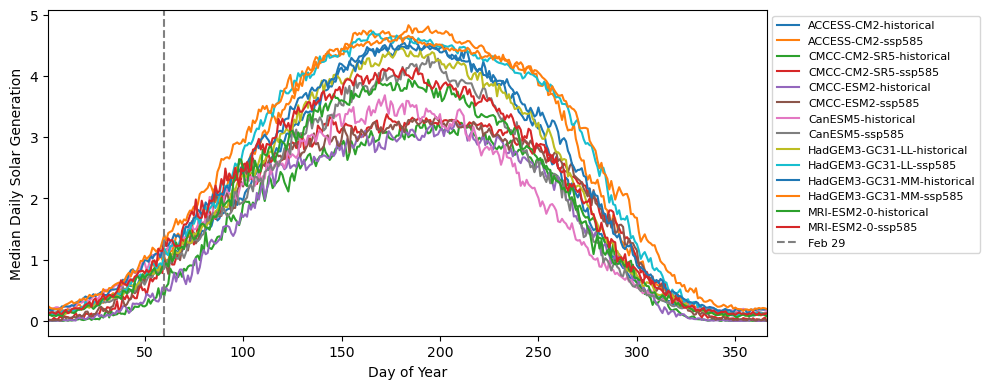

In [4]:
import os, glob
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

diri     = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/power"
periods  = ["historical","ssp585"]
pattern  = "daily_solar_power_*.nc"

def preprocess(ds):
    return ds.drop_vars("weekofyear", errors="ignore")

def preprocess(ds):
    return ds.drop_vars("weekofyear", errors="ignore")

records = []

for model in models:
    for period in periods:
        files = sorted(glob.glob(os.path.join(
            diri, f"{model}_1x1grid", period, pattern
        )))
        if not files:
            continue

        ds = xr.open_mfdataset(
            files,
            concat_dim="time",
            combine="nested",
            preprocess=preprocess,
            decode_times=True,
            data_vars="minimal",
            coords="minimal",
            compat="override",
        )

        # 1) collapse spatial dims first
        sp_med = ds["specific generation"].median(dim=["y","x"])

        # 2) Group by day‐of‐year, then take the 50th percentile along time
        daily_median = (
            sp_med
            .groupby(sp_med.time.dt.dayofyear)
            .quantile(0.5, dim="time")    # 0.5 quantile == median
        )

        # Convert to pandas Series, then name & reset index
        series = daily_median.to_series().rename("median_gen")
        clim   = series.reset_index()   # yields DataFrame with ['dayofyear','median_gen']

        # Add metadata
        clim["model"]  = model
        clim["period"] = period
        records.append(clim)

        ds.close()

clim_df = pd.concat(records, ignore_index=True)

# Plot to verify
plt.figure(figsize=(10,4))
for (m, p), grp in clim_df.groupby(["model","period"]):
    plt.plot(grp["dayofyear"], grp["median_gen"], label=f"{m}-{p}")
plt.axvline(60, color="gray", ls="--", label="Feb 29")
plt.xlim(1,366)
plt.xlabel("Day of Year")
plt.ylabel("Median Daily Solar Generation")
plt.legend(bbox_to_anchor=(1,1), fontsize=8)
plt.tight_layout()
plt.show()

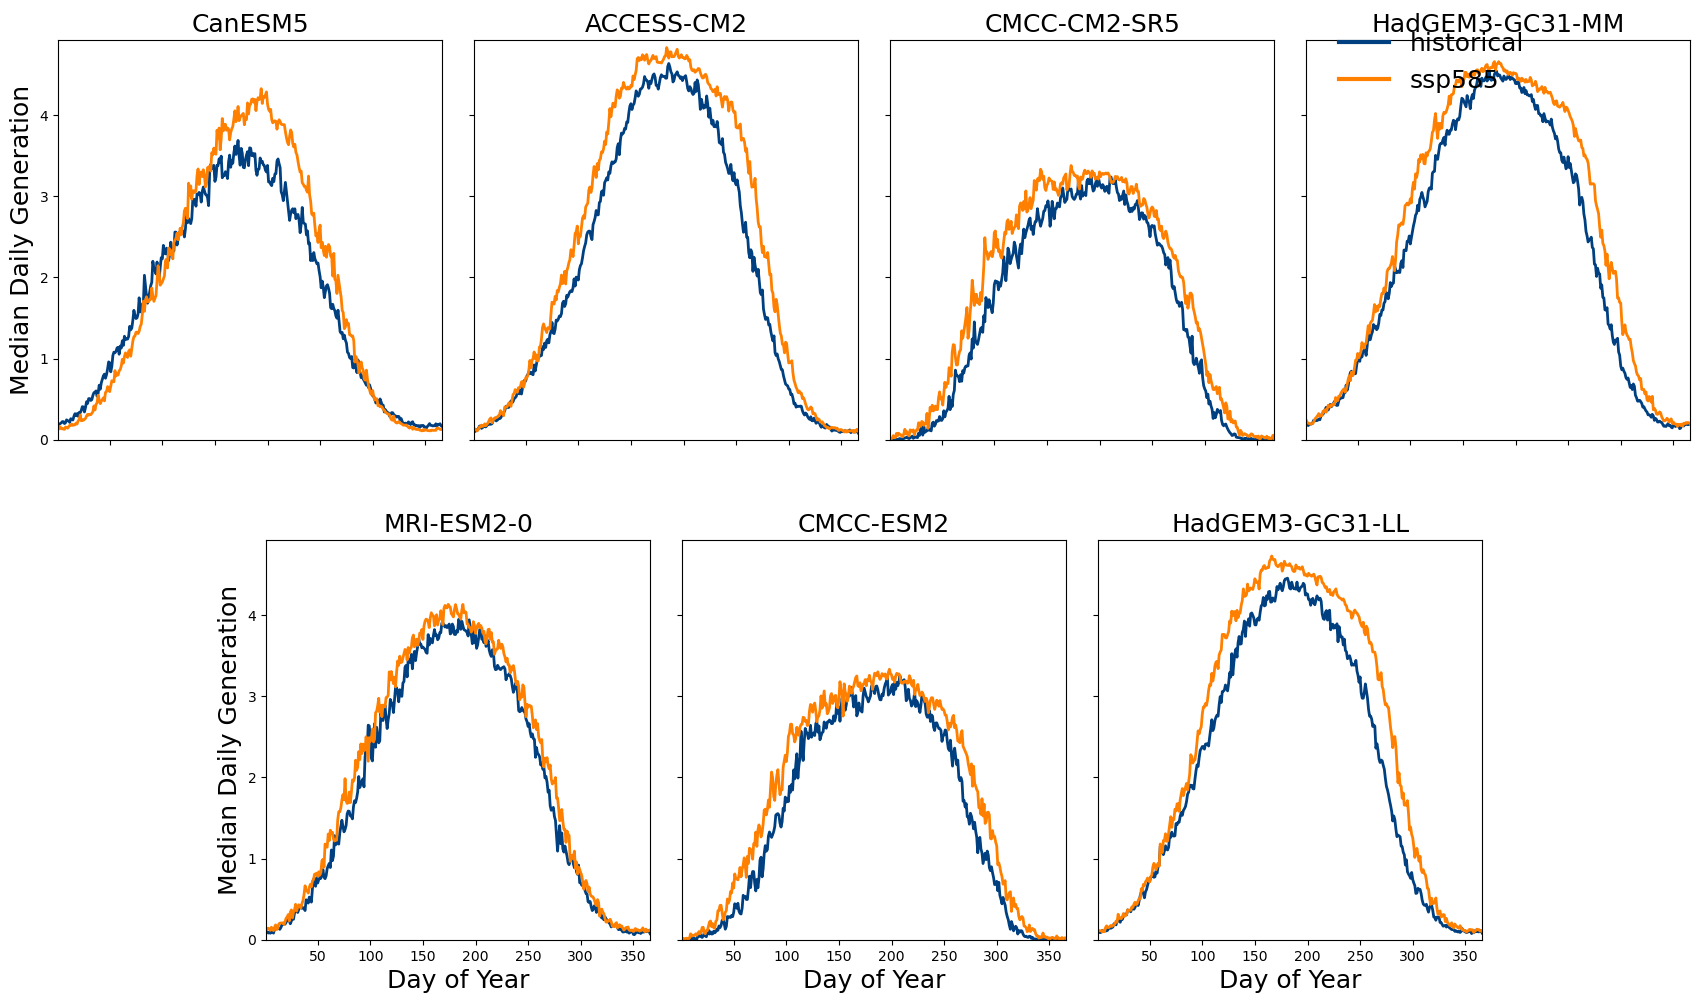

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `clim_df` from before, with columns:
#   'model', 'period', 'dayofyear', 'median_gen'
periods = ['historical','ssp585']
colors  = {'historical':'#004080',  # dark blue
           'ssp585'     :'#FF8000'}  # dark orange

# figure and layout parameters
fig = plt.figure(figsize=(16,10))
hp = 0.24    # panel width
vp_top    = 0.55
vp_bot    = 0.05
hpad      = 0.02
panel_h   = 0.4

# Top row (4 models)
for i, model in enumerate(models[:4]):
    left = 0.02 + i*(hp + hpad)
    ax = fig.add_axes([left, vp_top, hp, panel_h])
    
    for period in periods:
        grp = clim_df[(clim_df.model==model) & (clim_df.period==period)]
        ax.plot(grp['dayofyear'], grp['median_gen'],
                color=colors[period], lw=2, label=period)
    
    ax.set_title(model, fontsize=18)
    ax.set_xlim(1,366)
    ax.set_ylim(clim_df['median_gen'].min(), clim_df['median_gen'].max()*1.02)
    
    # only first column gets y‐label
    if i==0:
        ax.set_ylabel("Median Daily Generation", fontsize=18)
    else:
        ax.set_yticklabels([])
    # no x‐labels on top row
    ax.set_xticklabels([])

# Bottom row (3 models centered under cols 1–3)
for j, model in enumerate(models[4:]):
    left = 0.02 + (j+0.5)*(hp + hpad)
    ax = fig.add_axes([left, vp_bot, hp, panel_h])
    
    for period in periods:
        grp = clim_df[(clim_df.model==model) & (clim_df.period==period)]
        ax.plot(grp['dayofyear'], grp['median_gen'],
                color=colors[period], lw=2, label=period)
    
    ax.set_title(model, fontsize=18)
    ax.set_xlim(1,366)
    ax.set_ylim(clim_df['median_gen'].min(), clim_df['median_gen'].max()*1.02)
    
    # only first column gets y‐label
    if j==0:
        ax.set_ylabel("Median Daily Generation", fontsize=18)
    else:
        ax.set_yticklabels([])
    # bottom row gets x‐label
    ax.set_xlabel("Day of Year", fontsize=18)

# shared legend in top-right corner
leg_ax = fig.add_axes([0.85, 0.88, 0.1, 0.1])
leg_ax.axis('off')
for period in periods:
    leg_ax.plot([], [], color=colors[period], lw=3, label=period)
leg = leg_ax.legend(frameon=False, fontsize=18, title="")
plt.setp(leg.get_title(), fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()


/tmp/ipykernel_101970/3949414039.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


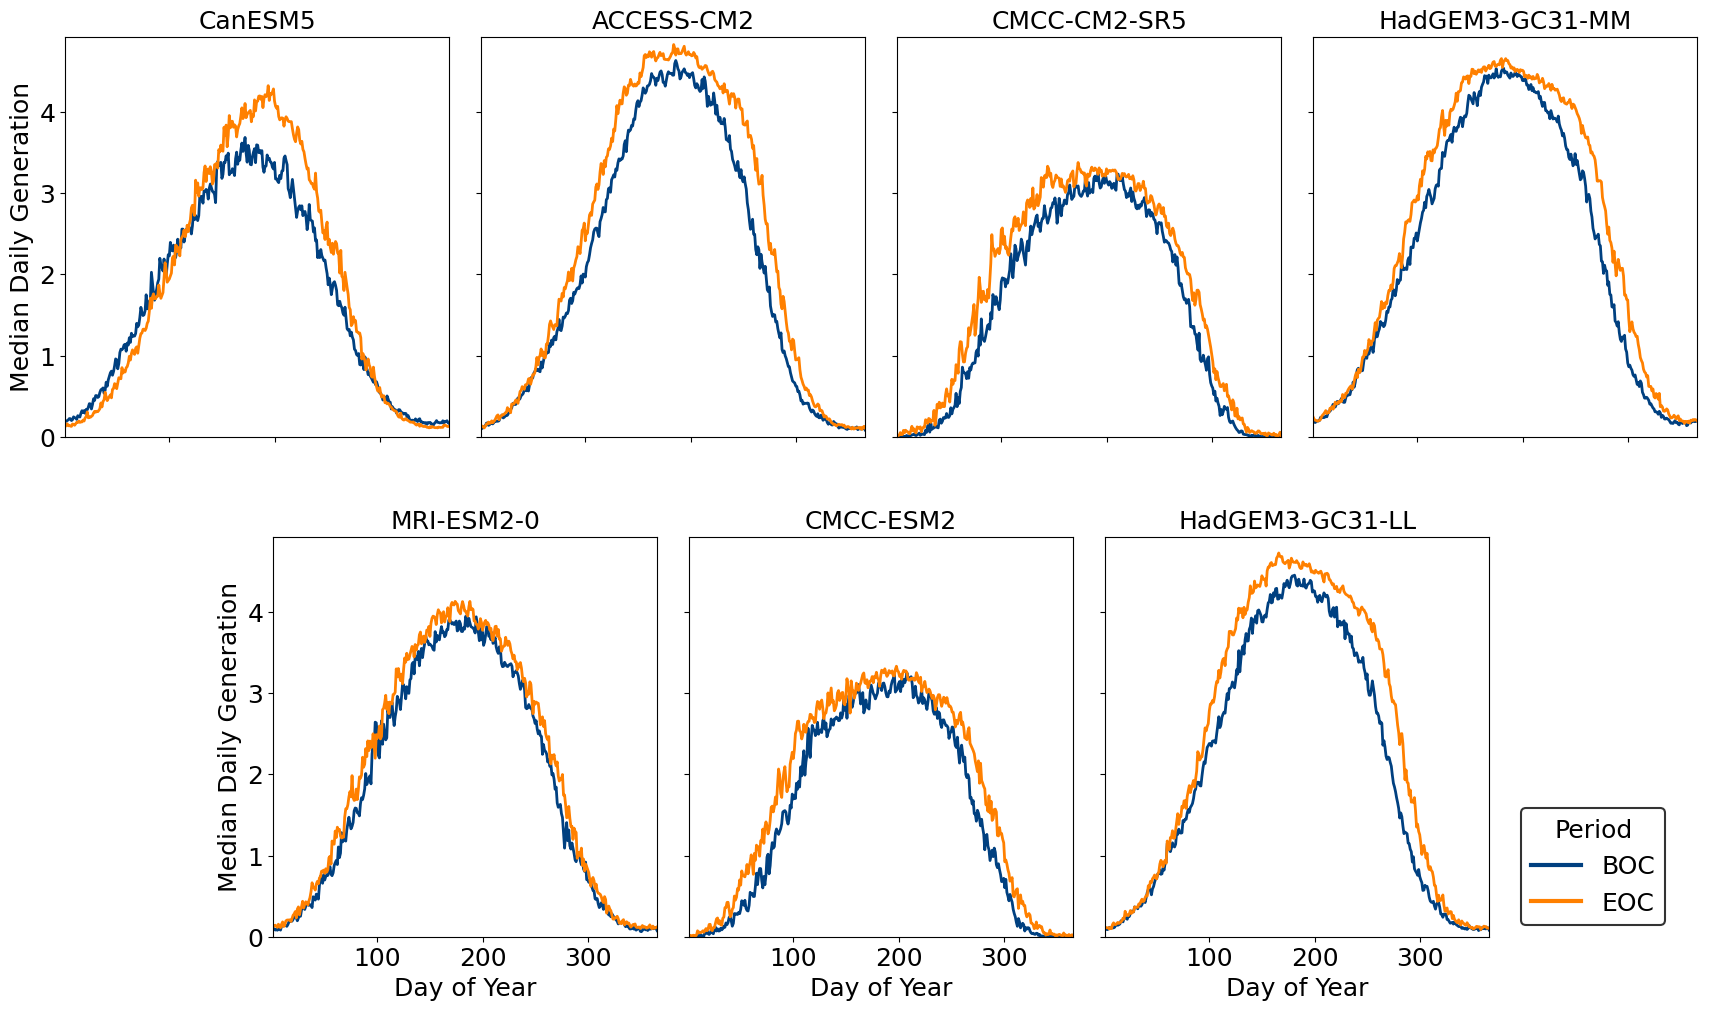

In [16]:
import numpy as np
import matplotlib.pyplot as plt

periods = ['historical','ssp585']
colors  = {'historical':'#004080',  # dark blue
           'ssp585'     :'#FF8000'}  # dark orange
label_map = {'historical':'BOC', 'ssp585':'EOC'}

fig = plt.figure(figsize=(16,10))
hp      = 0.24   # panel width
vp_top  = 0.55
vp_bot  = 0.05
hpad    = 0.02
panel_h = 0.4

# Top row (4 models)
for i, model in enumerate(models[:4]):
    left = 0.02 + i*(hp + hpad)
    ax = fig.add_axes([left, vp_top, hp, panel_h])
    
    for period in periods:
        grp = clim_df[(clim_df.model==model) & (clim_df.period==period)]
        ax.plot(grp['dayofyear'], grp['median_gen'],
                color=colors[period], lw=2, label=label_map[period])
    
    ax.set_title(model, fontsize=18)
    ax.set_xlim(1,366)
    ax.set_ylim(clim_df['median_gen'].min(), clim_df['median_gen'].max()*1.02)
    
    # enlarge ticks
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    
    # only first column shows y‐axis
    if i==0:
        ax.set_ylabel("Median Daily Generation", fontsize=18)
    else:
        ax.set_yticklabels([])
    ax.set_xticklabels([])

# Bottom row (3 models centered under cols 1–3)
for j, model in enumerate(models[4:]):
    left = 0.02 + (j+0.5)*(hp + hpad)
    ax = fig.add_axes([left, vp_bot, hp, panel_h])
    
    for period in periods:
        grp = clim_df[(clim_df.model==model) & (clim_df.period==period)]
        ax.plot(grp['dayofyear'], grp['median_gen'],
                color=colors[period], lw=2, label=label_map[period])
    
    ax.set_title(model, fontsize=18)
    ax.set_xlim(1,366)
    ax.set_ylim(clim_df['median_gen'].min(), clim_df['median_gen'].max()*1.02)
    
    # enlarge ticks
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    
    # only first col shows y‐axis
    if j==0:
        ax.set_ylabel("Median Daily Generation", fontsize=18)
    else:
        ax.set_yticklabels([])
    ax.set_xlabel("Day of Year", fontsize=18)

# shared legend in bottom-right corner
leg_ax = fig.add_axes([0.9, 0.02, 0.15, 0.2])
leg_ax.axis('off')
for period in periods:
    leg_ax.plot([], [], color=colors[period], lw=3, label=label_map[period])
# shared legend in bottom-right corner
leg_ax = fig.add_axes([0.9, 0.02, 0.15, 0.2])
leg_ax.axis('off')
for period in periods:
    leg_ax.plot([], [], color=colors[period], lw=3, label=label_map[period])

# turn the legend frame on and give it a black edge
leg = leg_ax.legend(
    frameon=True,
    edgecolor='black',
    facecolor='white',
    fontsize=18,
    title="Period",
    loc="center"
)
plt.setp(leg.get_title(), fontsize=18)

# optionally bump up the frame linewidth
frame = leg.get_frame()
frame.set_linewidth(1.5)

plt.tight_layout()
#plt.savefig("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/daily_power_per_model.pdf", bbox_inches='tight', dpi=300)
plt.show()

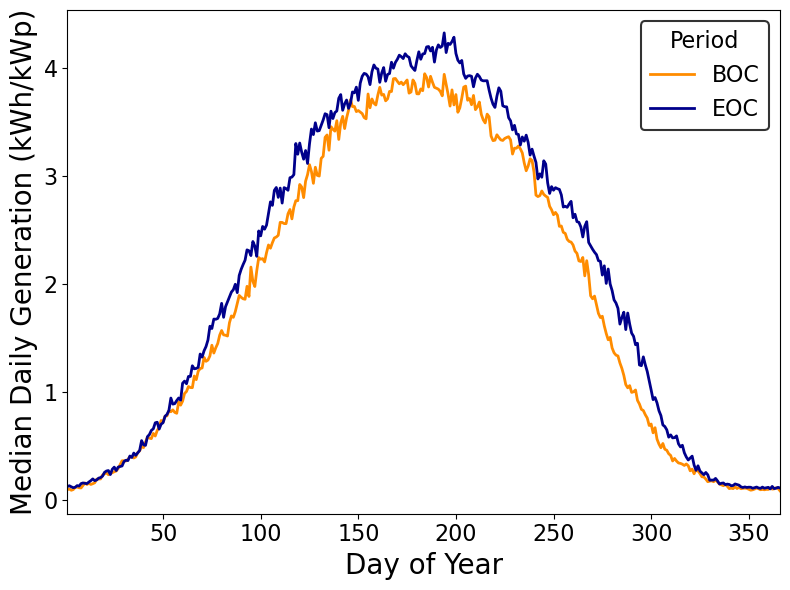

In [37]:
# 2) plot the two curves
plt.figure(figsize=(8,6))

# map file‐period → label & color
label_map = {"historical": "BOC", "ssp585": "EOC"}
colors    = {"BOC": "darkorange",  "EOC": "darkblue"}

for period, grp in daily_median_all.groupby("period"):
    lbl = label_map.get(period, period)
    plt.plot(
        grp["dayofyear"],
        grp["median_gen"],
        color=colors[lbl],
        lw=2,
        label=lbl
    )


# axes & legend
plt.xlim(1, 366)
plt.xlabel("Day of Year", fontsize=20)
plt.ylabel("Median Daily Generation (kWh/kWp)", fontsize=20)
plt.legend(title="Period", fontsize=16, title_fontsize=16, loc="upper right")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
leg = plt.legend(
    title="Period",
    fontsize=16,
    title_fontsize=16,
    loc="upper right",
    frameon=True,
    edgecolor="black",    # add black edge
    facecolor="white"     # ensure white background
)

# optionally bump up the frame line‐width
frame = leg.get_frame()
frame.set_linewidth(1.5)

plt.tight_layout()

plt.savefig("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation-backup/figures/daily_profile.pdf", bbox_inches='tight', dpi=300)
plt.show()